In [ ]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00


Import library

In [ ]:
import lifetimes

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions


Import Dataset

In [ ]:
df = pd.read_excel("OnlineRetail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


View Data Range

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# **PREPROCESS**


In [ ]:
#Filtering Data
df = df[df['Quantity'] > 0 ]
df = df[df['UnitPrice'] > 0]
df = df[~df['InvoiceNo'].str.contains("C",na=False)]

In [ ]:
#replace missing value
df.dropna(inplace=True)

In [ ]:
#Handling Outliers
def find_boundaries(df, variable,q1=0.05,q2=0.95):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(q1)
    upper_boundary = df[variable].quantile(q2)

    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [ ]:
capping_outliers(df,'UnitPrice')
capping_outliers(df,'Quantity')
df.describe()

,Quantity,UnitPrice,CustomerID,Total Price
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,8.868022,2.675785,15294.423453,16.107655
std,9.523425,2.275053,1713.141560,20.717408
min,1.000000,0.420000,12346.000000,0.420000
25%,2.000000,1.250000,13969.000000,4.950000
50%,6.000000,1.950000,15159.000000,11.250000
75%,12.000000,3.750000,16795.000000,17.700000
max,36.000000,8.500000,18287.000000,306.000000


Creating Columns Total Price

In [ ]:
df['Total Price'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# **Creating Summary Dataset**
By using lifetimes we can also create our RFM data from the original dataset.

- **Frequency** represents the number of repeat purchases the customer has made.
This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

- **Recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

- **Monetary_Value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

In [ ]:
#View data range
print("Date range: %s to %s" % (df["InvoiceDate"].min(), df["InvoiceDate"].max()))

Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
clv = lifetimes.utils.summary_data_from_transaction_data(df,'CustomerID','InvoiceDate','Total Price',observation_period_end='2011-12-09')

In [ ]:
clv = clv[clv['frequency']>1] # we want only customers shopped more than 2 times

In [ ]:
clv.head(10)

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,550.570000
12348.0,3.0,283.0,358.0,116.126667
12352.0,6.0,260.0,296.0,192.840000
12356.0,2.0,303.0,325.0,226.080000
12359.0,3.0,274.0,331.0,1495.650000
12360.0,2.0,148.0,200.0,685.140000
12362.0,9.0,292.0,295.0,494.126667
12364.0,3.0,105.0,112.0,204.500000
12370.0,3.0,309.0,360.0,583.090000


BG/NBD Model for Predicting Number of Purchase

In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequency'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1916 subjects, a: 0.00, alpha: 109.98, b: 0.00, r: 2.35>

In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.352230e+00,9.460913e-02,2.166796e+00,2.537663e+00
alpha,1.099756e+02,4.886129e+00,1.003987e+02,1.195524e+02
a,7.059485e-17,2.153800e-11,-4.221440e-11,4.221454e-11
b,1.185774e-06,3.617539e-01,-7.090364e-01,7.090388e-01


Visualizing our Frequency/Recency Matrix

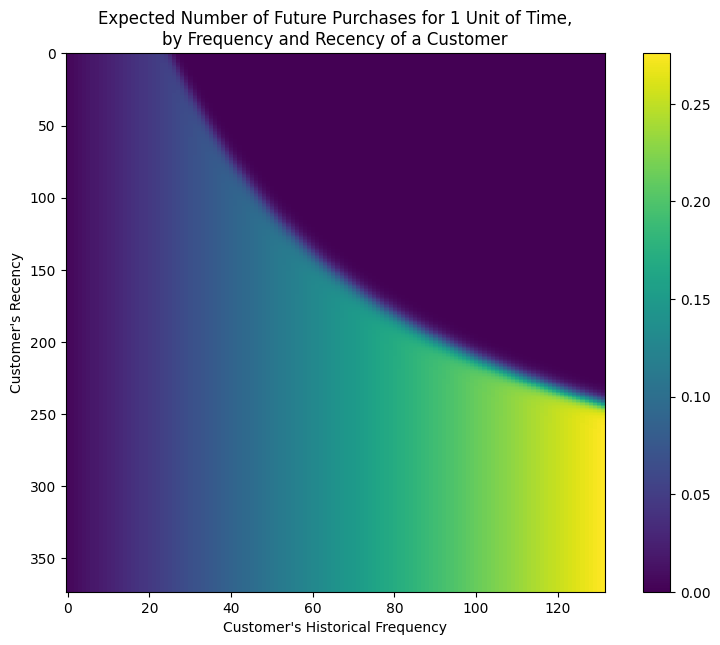

In [ ]:
plt.figure(figsize=(10,7))
plot_frequency_recency_matrix(bgf)
plt.show()

Expected Number of Purchases in 3 Months

In [ ]:
t = 90 # 30 day period
clv['expected_purc_3_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purc_3_months',ascending=False).head(5)

,frequency,recency,T,monetary_value,expected_purc_3_months
CustomerID,,,,,
14911.0,131.0,372.0,373.0,917.278855,24.849499
12748.0,112.0,373.0,373.0,257.314911,21.308947
17841.0,111.0,372.0,373.0,349.079640,21.122603
15311.0,89.0,373.0,373.0,421.881573,17.023016
14606.0,88.0,372.0,373.0,125.302955,16.836671


Gamma - Gamma Model

In [ ]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.110771
monetary_value,0.110771,1.000000


In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1916 subjects, p: 3.79, q: 0.34, v: 3.72>

3 months Customer Lifetime Value

In [ ]:
clv['3_Months_CLV']=ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=3,
                                   freq='D',
                                   discount_rate=0.01)


In [ ]:
clv.sort_values('3_Months_CLV',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purc_3_months,3_Months_CLV
CustomerID,,,,,,
14096.0,16.0,97.0,101.0,3012.454375,7.828872,23374.883280
14911.0,131.0,372.0,373.0,917.278855,24.849499,22375.789863
14646.0,44.0,353.0,354.0,2507.804091,8.991208,22192.692392
14156.0,42.0,362.0,371.0,1366.275476,8.299176,11162.637137
18102.0,25.0,367.0,367.0,2112.843200,5.161063,10765.307175


Segmentation Customers by 3 Months CLV

In [ ]:
clv['Segment'] =  pd.qcut(clv['3_Months_CLV'],4,labels = ['Very Risk','Risk',
                                                          'Loyal Customer','VIP'])

In [ ]:
clv.head()

,frequency,recency,T,monetary_value,expected_purc_3_months,3_Months_CLV,Segment
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,550.570000,1.575973,876.874227,VIP
12348.0,3.0,283.0,358.0,116.126667,1.029329,125.686624,Very Risk
12352.0,6.0,260.0,296.0,192.840000,1.851591,361.596640,Risk
12356.0,2.0,303.0,325.0,226.080000,0.900512,220.295189,Very Risk
12359.0,3.0,274.0,331.0,1495.650000,1.092352,1701.132737,VIP


In [ ]:
clv.groupby('Segment').mean()

,frequency,recency,T,monetary_value,expected_purc_3_months,3_Months_CLV
Segment,,,,,,
Very Risk,3.169102,220.565762,291.824635,148.661593,1.276251,187.489547
Risk,4.018789,239.442589,282.941545,270.869214,1.502015,387.477844
Loyal Customer,5.682672,241.569937,273.110647,369.673664,1.917306,648.020197
VIP,11.244259,264.486430,284.411273,636.264425,3.003776,1733.564181
